In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import imageio

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.transforms import ToPILImage
#from IPython.display import Image
to_img = ToPILImage()

from scipy.misc import imread, imresize

import copy
from tqdm import tqdm


In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

print (use_cuda)

True


In [56]:
vgg19 = models.vgg19(pretrained=True).features

if use_cuda:
    vgg19.cuda()

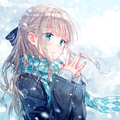

In [70]:
style_img = Image.open('data/style.jpeg')
style_img = style_img.resize((120, 120), Image.ANTIALIAS)

# np_style_img = np.array(style_img)
# np_style_img[:, :, 0] = np_style_img[:, :, 0] - 103.939
# np_style_img[:, :, 1] = np_style_img[:, :, 1] - 116.779
# np_style_img[:, :, 2] = np_style_img[:, :, 2] - 123.68

# style_img = Image.fromarray(np_style_img)

style_img

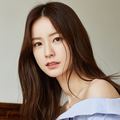

In [71]:
content_img = Image.open('data/content.jpeg')
content_img = content_img.resize((120, 120), Image.ANTIALIAS)

# np_content_img = np.array(content_img)
# np_content_img[:, :, 0] = np_content_img[:, :, 0] - 103.939
# np_content_img[:, :, 1] = np_content_img[:, :, 1] - 116.779
# np_content_img[:, :, 2] = np_content_img[:, :, 2] - 123.68

# content_img = Image.fromarray(np_content_img)

content_img

In [73]:
preprocess = transforms.Compose([
   transforms.ToTensor(),
])

style_img_tensor = preprocess(style_img).type(dtype)
style_img_tensor = style_img_tensor.view(1, 3, 120, 120)
style_img_variable = Variable(style_img_tensor)
print(style_img_variable.size())

content_img_tensor = preprocess(content_img).type(dtype)
content_img_tensor = content_img_tensor.view(1, 3, 120, 120)
content_img_variable = Variable(content_img_tensor)
print(content_img_variable.size())

torch.Size([1, 3, 120, 120])
torch.Size([1, 3, 120, 120])


In [74]:
output = vgg19(style_img_variable)
print (output.shape)

torch.Size([1, 512, 3, 3])


In [75]:
vgg19

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=(2, 2), stride=(

In [76]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t()) 
        return G.div(a * b * c * d)

In [77]:
class Net(nn.Module):
    def __init__(self, vgg19_model):
        super(Net, self).__init__()

        # Conv1
        self.conv1_1 = vgg19_model[0]
        self.relu1_1 = vgg19_model[1]

        self.conv1_2 = vgg19_model[2]
        self.relu1_2 = vgg19_model[3]
        self.pool1 = vgg19_model[4]

        # Conv2
        self.conv2_1 = vgg19_model[5]
        self.relu2_1 = vgg19_model[6]

        self.conv2_2 = vgg19_model[7]
        self.relu2_2 = vgg19_model[8]
        self.pool2 = vgg19_model[9]

        # Conv3
        self.conv3_1 = vgg19_model[10]
        self.relu3_1 = vgg19_model[11]

        self.conv3_2 = vgg19_model[12]
        self.relu3_2 = vgg19_model[13]

        self.conv3_3 = vgg19_model[14]
        self.relu3_3 = vgg19_model[15]

        self.conv3_4 = vgg19_model[16]
        self.relu3_4 = vgg19_model[17]
        self.pool3 = vgg19_model[18]

        # Conv4

        self.conv4_1 = vgg19_model[19]
        self.relu4_1 = vgg19_model[20]

        self.conv4_2 = vgg19_model[21]
        self.relu4_2 = vgg19_model[22]

        self.conv4_3 = vgg19_model[23]
        self.relu4_3 = vgg19_model[24]

        self.conv4_4 = vgg19_model[25]
        self.relu4_4 = vgg19_model[26]
        self.pool4 = vgg19_model[27]

        # Conv5

        self.conv5_1 = vgg19_model[28]
        self.relu5_1 = vgg19_model[29]

        self.conv5_2 = vgg19_model[30]
        self.relu5_2 = vgg19_model[31]

        self.conv5_3 = vgg19_model[32]
        self.relu5_3 = vgg19_model[33]

        self.conv5_4 = vgg19_model[34]
        self.relu5_4 = vgg19_model[35]
        self.pool5 = vgg19_model[36]

    def forward(self, x):
        conv1_1 = self.conv1_1(x)
        relu1_1 = self.relu1_1(conv1_1)

        conv1_2 = self.conv1_2(relu1_1)
        relu1_2 = self.relu1_2(conv1_2)
        pool1 = self.pool1(relu1_2)

        # Conv2
        conv2_1 = self.conv2_1(pool1)
        relu2_1 = self.relu2_1(conv2_1)

        conv2_2 = self.conv2_2(relu2_1)
        relu2_2 = self.relu2_2(conv2_2)
        pool2 = self.pool2(relu2_2)

        # Conv3
        conv3_1 = self.conv3_1(pool2)
        relu3_1 = self.relu3_1(conv3_1)

        conv3_2 = self.conv3_2(relu3_1)
        relu3_2 = self.relu3_2(conv3_2)

        conv3_3 = self.conv3_3(relu3_2)
        relu3_3 = self.relu3_3(conv3_3)

        conv3_4 = self.conv3_4(relu3_3)
        relu3_4 = self.relu3_4(conv3_4)
        pool3 = self.pool3(relu3_4)

        # Conv4

        conv4_1 = self.conv4_1(pool3)
        relu4_1 = self.relu4_1(conv4_1)

        conv4_2 = self.conv4_2(relu4_1)
        relu4_2 = self.relu4_2(conv4_2)

        conv4_3 = self.conv4_3(relu4_2)
        relu4_3 = self.relu4_3(conv4_3)

        conv4_4 = self.conv4_4(relu4_3)
        relu4_4 = self.relu4_4(conv4_4)
        pool4 = self.pool4(relu4_4)

        # Conv5

        conv5_1 = self.conv5_1(pool4)
#         relu5_1 = self.relu5_1(conv5_1)

#         conv5_2 = self.conv5_2(relu5_1)
#         relu5_2 = self.relu5_2(conv5_2)

#         conv5_3 = self.conv5_3(relu5_2)
#         relu5_3 = self.relu5_3(conv5_3)

#         conv5_4 = self.conv5_4(relu5_3)
#         relu5_4 = self.relu5_4(conv5_4)
#         pool5 = self.pool5(relu5_4)

        return conv1_1, conv2_1, conv3_1, conv4_1, conv5_1, conv4_2
        
net = Net(vgg19)

if use_cuda:
    net.cuda()

In [91]:
# Loss and Optimizer
#input_img = content_img_variable.clone()
input_img = torch.randn(1, 3, 120, 120).type(dtype)
input_param = nn.Parameter(input_img)

optimizer = optim.LBFGS([input_param], lr=1)

criterion = nn.MSELoss()

gram = GramMatrix()
if use_cuda:
    gram.cuda()


In [92]:
#from tensorboard_logger import configure, log_value
import numpy as np
#configure("runs/run-1")

w = [0.2, 0.2, 0.2, 0.2, 0.2]
style_weight = 1000.0
content_weight = 1.0
max_step = 3000000

run = [0]

while run[0] < max_step:
    def closure():
        run[0] += 1
        optimizer.zero_grad()

        layers = net(input_param)

        content_loss_target = net(content_img_variable)[5].detach()
        content_loss = criterion(layers[5], content_loss_target)       
        content_loss.backward(retain_graph=True)
        
        style_targets = net(style_img_variable)
        style_targets = style_targets[:-1]
        style_loss_total = 0
        for i, style_target in enumerate(style_targets):
            style_target_gram = gram(style_target.detach())
            style_gram = gram(layers[i])            
            style_loss = criterion(style_gram, style_target_gram)
            style_loss.backward(retain_graph=True)
            style_loss_total += style_loss * w[i]
            
        total_loss = content_loss * content_weight + style_loss_total * style_weight
        #total_loss.backward()
        
#         log_value('total_loss', total_loss.data, run[0])
#         log_value('style_loss', style_loss.data, run[0])
#         log_value('content_loss', content_loss.data, run[0])
    
        if (run[0] % 10 == 0):
            print("style loss: " + str(style_loss_total.data))
            print("content loss: " + str(content_loss.data))
            
        if run[0] % 100 == 0:
            torchvision.utils.save_image(input_param.data, ".\\output_\\" + str(run[0]) + ".jpeg")
        
        return total_loss
    
#     if run[0] % 100 == 0:
# #         img_np = input_param.data.cpu().numpy()
# #         img_max = np.max(np.max(img_np))
# #         img_np /= img_max 
# #         torchvision.utils.save_image(torch.from_numpy(img_np), ".\\output\\" + str(run[0]) + ".jpeg")
        
#         #to_img(input_param[0].data.cpu())
            
    optimizer.step(closure)     

style loss: 
1.00000e-03 *
  2.5715
[torch.cuda.FloatTensor of size 1 (GPU 0)]

content loss: 
 5.3169
[torch.cuda.FloatTensor of size 1 (GPU 0)]

style loss: 
1.00000e-03 *
  2.7537
[torch.cuda.FloatTensor of size 1 (GPU 0)]

content loss: 
 2.7813
[torch.cuda.FloatTensor of size 1 (GPU 0)]

style loss: 
1.00000e-03 *
  2.7629
[torch.cuda.FloatTensor of size 1 (GPU 0)]

content loss: 
 1.8924
[torch.cuda.FloatTensor of size 1 (GPU 0)]

style loss: 
1.00000e-03 *
  2.6960
[torch.cuda.FloatTensor of size 1 (GPU 0)]

content loss: 
 1.3823
[torch.cuda.FloatTensor of size 1 (GPU 0)]

style loss: 
1.00000e-03 *
  2.6037
[torch.cuda.FloatTensor of size 1 (GPU 0)]

content loss: 
 1.0738
[torch.cuda.FloatTensor of size 1 (GPU 0)]

style loss: 
1.00000e-03 *
  2.5231
[torch.cuda.FloatTensor of size 1 (GPU 0)]

content loss: 
 0.8625
[torch.cuda.FloatTensor of size 1 (GPU 0)]

style loss: 
1.00000e-03 *
  2.4546
[torch.cuda.FloatTensor of size 1 (GPU 0)]

content loss: 
 0.7164
[torch.cuda.Flo

KeyboardInterrupt: 

In [ ]:
input_param[0].data.cpu()